# <div align='center'>  **Time Series Alignment with Global Invariances** </div>

## **Setup**

### Imports

In [ ]:
from dataclasses import dataclass
from typing import Optional, List, Tuple, Iterable

import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tslearn.metrics import dtw_path, soft_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter

import pandas as pd
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import torch
import torch.nn as nn
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## **DTW-Based Distances** 

### DTW path computation

In [3]:
def compute_dtw_path(    
    x: np.ndarray,
    y: np.ndarray,
) -> Tuple[List[Tuple[int, int]], float]:

    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    path, _ = dtw_path(x, y)

    cost = sum(
        np.sum((x[i] - y[j]) ** 2)
        for i, j in path
    )

    path = [(int(i), int(j)) for i, j in path]
    return path, float(cost)

In [4]:
def path_to_W(
    path: Iterable[Tuple[int, int]],
    Tx: int,
    Ty: int,
) -> np.ndarray:
    """
    Build alignment matrix Wπ ∈ {0,1}^{Tx×Ty} from a DTW warping path.

    This is the exact equivalent of the authors' `path2mat`.
    """
    W = np.zeros((Tx, Ty), dtype=np.float64)
    for i, j in path:
        W[i, j] = 1.0
    return W

### Procrustes update on the Stiefel manifold

In [5]:
@dataclass(frozen=True)
class StiefelUpdateResult:
    P: np.ndarray                 # (px, py)
    M: np.ndarray                 # (px, py)
    singular_values: np.ndarray   # (min(px, py),)


def stiefel_procrustes_update(
    x: np.ndarray,
    y: np.ndarray,
    W: np.ndarray,
) -> StiefelUpdateResult:
    """
    Procrustes update on the Stiefel manifold.

    Solves:
        P* = argmax_{P^T P = I} < x^T W y, P >

    via SVD:
        M = x^T W y = U S V^T
        P = U V^T

    Shapes:
        x: (Tx, px)
        y: (Ty, py)
        W: (Tx, Ty)

    Returns:
        P: (px, py)
    """
    if x.ndim != 2 or y.ndim != 2 or W.ndim != 2:
        raise ValueError("x, y, W must be 2D arrays.")

    Tx, px = x.shape
    Ty, py = y.shape

    if W.shape != (Tx, Ty):
        raise ValueError(
            f"W must have shape (Tx, Ty)=({Tx},{Ty}), got {W.shape}"
        )

    M = x.T @ W @ y        # (px, py)

    # SVD 
    U, S, Vt = np.linalg.svd(M, full_matrices=False)

    # Stiefel solution
    P = U @ Vt             # (px, py)

    return StiefelUpdateResult(P=P, M=M, singular_values=S)



def apply_linear_map(y: np.ndarray, P: np.ndarray) -> np.ndarray:
    """
    Apply f(y) = y P^T

    y: (Ty, py)
    P: (px, py)
    returns: (Ty, px)
    """
    if y.ndim != 2 or P.ndim != 2:
        raise ValueError("y and P must be 2D arrays.")

    px, py = P.shape
    if y.shape[1] != py:
        raise ValueError(
            f"y has feature dim {y.shape[1]}, expected py={py}"
        )

    return y @ P.T


def random_stiefel(px: int, py: int, rng: np.random.Generator) -> np.ndarray:
    """
    Sample a random matrix P ∈ V_{py,px} (orthonormal columns).
    """
    A = rng.standard_normal((px, py))
    Q, _ = np.linalg.qr(A)
    return Q[:, :py]

### DTW with Global Invariances using Block Coordinate Descent

In [6]:
@dataclass(frozen=True)
class BCDResult:
    P: np.ndarray                  # (px, py)
    path: List[Tuple[int, int]]    # DTW alignment on last iteration
    cost: float                    # DTW cost on last iteration (with transformed y)
    n_iter: int
    cost_history: List[float]



def dtw_gi(
    x: np.ndarray,
    y: np.ndarray,
    max_iter: int = 100,
    init_P: Optional[np.ndarray] = None,
    verbose: bool = False
) -> BCDResult:
    """
    BCD for DTW-GI when F is Stiefel (rigid linear map):
      - x: (Tx, px)
      - y: (Ty, py), assume px >= py
      - P: (px, py), and we compare x with y @ P^T in DTW step

    Iteration:
      1) path <- DTW(x, y P^T)
      2) W <- path_to_w(path)
      3) M <- x^T W y
      4) P <- stiefel_procrustes(M)
    """
    if x.ndim != 2 or y.ndim != 2:
        raise ValueError("x and y must be 2D arrays: (T, p).")
    tx, px = x.shape
    ty, py = y.shape
    if px < py:
        raise ValueError(f"Require px >= py for Stiefel V_{py,px}. Got px={px}, py={py}.")

    if init_P is None:
        # Identity embedding: first py coordinates
        P = np.zeros((px, py), dtype=np.float64)
        P[:py, :py] = np.eye(py)
    else:
        P = np.array(init_P, dtype=np.float64, copy=True)
        if P.shape != (px, py):
            raise ValueError(f"init_P must have shape (px, py)=({px},{py}), got {P.shape}.")

    prev_cost = np.inf
    last_path: List[Tuple[int, int]] = []
    last_cost: float = np.inf
    prev_path = None
    cost_history = []

    for it in range(1, max_iter + 1):
        # DTW alignment with transformed y
        yP = y @ P.T  # (Ty, px)
        path, cost = compute_dtw_path(x, yP)
        cost_history.append(cost)

        # build W and update P via SVD (Eq. 17 / Alg. 1)
        W = path_to_W(path, Tx=tx, Ty=ty)  # (Tx, Ty)
        res = stiefel_procrustes_update(x, y, W)
        P = res.P

        # convergence check
        if verbose:
            print(f"[BCD] iter={it:03d} cost={cost:.6f} Δ={prev_cost - cost:.6e}")

        if prev_path is not None and path == prev_path:
            break
        
        prev_path = path
        prev_cost = cost
        last_path, last_cost = path, float(cost)

    return BCDResult(P=P, path=last_path, cost=last_cost, n_iter=max_iter, cost_history=cost_history)




def dtw_gi_multistart(
    x: np.ndarray,
    y: np.ndarray,
    *,
    max_iter: int = 20,
    n_random_starts: int = 5,
    seed: int = 0,
    verbose: bool = False
) -> BCDResult:
    """
    Multi-start DTW-GI using BCD on the Stiefel manifold.

    Runs BCD from:
      - identity initialization
      - n_random_starts random Stiefel initializations

    Returns the solution with minimal final cost.
    """
    Tx, px = x.shape
    _, py = y.shape

    rng = np.random.default_rng(seed)

    candidates: list[BCDResult] = []

    # Identity initialization 
    P_id = np.eye(px, py)
    res_id = dtw_gi(
        x,
        y,
        max_iter=max_iter,
        init_P=P_id,
        verbose=False
    )
    candidates.append(res_id)

    if verbose:
        print(f"[Multi-start DTW-GI] identity cost = {res_id.cost:.6f}")

    #  Random Stiefel initializations 
    for k in range(n_random_starts):
        P0 = random_stiefel(px, py, rng)
        res = dtw_gi(
            x,
            y,
            max_iter=max_iter,
            init_P=P0,
            verbose=False
        )
        candidates.append(res)

        if verbose:
            print(f"[Multi-start DTW-GI] random {k+1}/{n_random_starts} cost = {res.cost:.6f}")

    
    best = min(candidates, key=lambda r: r.cost)

    if verbose:
        print(
            f"[Multi-start DTW-GI] selected cost = {best.cost:.6f} "
            f"(n_iter={best.n_iter})"
        )

    return best

### SoftDTW-GI using Gradient Descent

In [7]:
def project_to_stiefel(P: np.ndarray) -> np.ndarray:
    """
    Projection onto Stiefel manifold via SVD: P <- U V^T
    """
    U, _, Vt = np.linalg.svd(P, full_matrices=False)
    return U @ Vt


def _apply_linear_map(y: np.ndarray, P: np.ndarray) -> np.ndarray:
    """
    f(y) = y @ P^T
    """
    return y @ P.T


def normalized_softdtw(x, y, gamma: float) -> float:
    """
    Normalized softDTW:
        softDTW(x, y)
        - 0.5 * (softDTW(x, x) + softDTW(y, y))
    """
    return (
        soft_dtw(x, y, gamma=gamma)
        - 0.5 * (soft_dtw(x, x, gamma=gamma) + soft_dtw(y, y, gamma=gamma))
    )


@dataclass(frozen=True)
class SoftDTWGIResult:
    P: np.ndarray
    loss_history: List[float]
    cost: float
    n_iter: int
    stopped_early: bool



def soft_dtw_gi(
    x: np.ndarray,
    y: np.ndarray,
    *,
    gamma: float = 1.0,
    max_iter: int = 50,
    lr: float = 1e-3,
    init_P: Optional[np.ndarray] = None,
    normalize: bool = True,
    early_stopping_patience: Optional[int] = 10,
    verbose: bool = False,
    step_verbose: int = 10,
) -> SoftDTWGIResult:
    """
    softDTW-GI implementation (Numpy, tslearn).

    Minimizes:
        softDTW(x, y @ P^T)
    or its normalized version, over P ∈ Stiefel.
    """

    if x.ndim != 2 or y.ndim != 2:
        raise ValueError("x and y must be 2D arrays (T, p).")

    Tx, px = x.shape
    Ty, py = y.shape

    # Initialization
    if init_P is None:
        P = np.eye(px, py)
    else:
        P = init_P.copy()

    P = project_to_stiefel(P)

    best_loss = np.inf
    best_P = P.copy()
    best_iter = -1

    loss_history: List[float] = []
    stopped_early = False

    # Gradient descent loop
    for it in range(1, max_iter + 1):
        yP = _apply_linear_map(y, P)

        if normalize:
            loss = normalized_softdtw(x, yP, gamma)
        else:
            loss = soft_dtw(x, yP, gamma=gamma)

        loss_history.append(loss)

        eps = 1e-6
        G = np.zeros_like(P)

        for i in range(px):
            for j in range(py):
                P_pert = P.copy()
                P_pert[i, j] += eps
                P_pert = project_to_stiefel(P_pert)
                yP_pert = _apply_linear_map(y, P_pert)

                if normalize:
                    loss_pert = normalized_softdtw(x, yP_pert, gamma)
                else:
                    loss_pert = soft_dtw(x, yP_pert, gamma=gamma)

                G[i, j] = (loss_pert - loss) / eps

        # gradient step + projection
        P = project_to_stiefel(P - lr * G)

        # bookkeeping
        if loss < best_loss:
            best_loss = loss
            best_P = P.copy()
            best_iter = it

        if verbose and (it == 1 or it % step_verbose == 0):
            print(
                f"[softDTW-GI] iter={it:04d} | "
                f"loss={loss:.6f} | "
                f"best={best_loss:.6f} @ {best_iter:04d}"
            )

        if (
            early_stopping_patience is not None
            and best_iter >= 0
            and (it - best_iter) > early_stopping_patience
        ):
            stopped_early = True
            if verbose:
                print(f"[softDTW-GI] early stop @ iter={it:04d}")
            break

    final_cost = best_loss

    return SoftDTWGIResult(
        P=best_P,
        loss_history=loss_history,
        cost=float(final_cost),
        n_iter=len(loss_history),
        stopped_early=stopped_early,
    )


In [66]:
def pairwise_euclidean_dist(x, y):
    x_norm = (x**2).sum(2).view(x.shape[0], x.shape[1], 1)
    y_norm = (y**2).sum(2).view(y.shape[0], 1, y.shape[1])
    dist = x_norm + y_norm - 2.0 * torch.bmm(x, y.transpose(1, 2))
    return torch.clamp(dist, 0.0, np.inf)

def soft_dtw_batch(x, y, gamma=0.1):
    B, N, _ = x.shape
    M = y.shape[1]
    dist = pairwise_euclidean_dist(x, y)
    R = torch.full((B, N + 2, M + 2), 1e10, device=x.device)
    R[:, 0, 0] = 0
    for j in range(1, M + 1):
        for i in range(1, N + 1):
            r0 = -R[:, i - 1, j - 1] / gamma
            r1 = -R[:, i - 1, j] / gamma
            r2 = -R[:, i, j - 1] / gamma
            rmax = torch.max(torch.max(r0, r1), r2)
            lse = rmax + torch.log(torch.exp(r0 - rmax) + torch.exp(r1 - rmax) + torch.exp(r2 - rmax))
            R[:, i, j] = dist[:, i - 1, j - 1] - gamma * lse
    return R[:, N, M]

def normalized_soft_dtw_batch(x, y, gamma):
    xy = soft_dtw_batch(x, y, gamma)
    xx = soft_dtw_batch(x, x, gamma)
    yy = soft_dtw_batch(y, y, gamma)
    return xy - 0.5 * (xx + yy)

def soft_dtw_batch_optimized(x, y, gamma=0.1):
    B, N, D = x.shape
    M = y.shape[1]

    dist = pairwise_euclidean_dist(x, y)  # (B, N, M)

    inf = 1e10
    R_prev = torch.full((B, N+1), inf, device=x.device)
    R_prev[:, 0] = 0

    for j in range(1, M+1):
        R_cur = torch.full((B, N+1), inf, device=x.device)

        for i in range(1, N+1):
            r0 = -R_prev[:, i-1] / gamma
            r1 = -R_prev[:, i]   / gamma
            r2 = -R_cur[:, i-1]  / gamma

            rmax = torch.maximum(torch.maximum(r0, r1), r2)
            lse = rmax + torch.log(torch.exp(r0 - rmax) +
                                    torch.exp(r1 - rmax) +
                                    torch.exp(r2 - rmax))

            R_cur[:, i] = dist[:, i-1, j-1] - gamma * lse

        R_prev = R_cur

    return R_prev[:, N]

def optimize_batch_gi_fast(y_query, X_lib_tensor, gamma=0.01, lr=0.5, max_iter=100, downsample=5):
    """
    Optimizes P using a downsampled time axis. 
    downsample=5 means we look at every 5th frame (10 frames total).
    This provides a ~25x speedup while still learning the spatial rotation P.
    """
    X_coarse = X_lib_tensor[:, ::downsample, :]
    y_coarse = y_query[::downsample, :]
    
    M, T_coarse, D = X_coarse.shape
    y_batch = torch.tensor(y_coarse, dtype=torch.float32, device=DEVICE).unsqueeze(0).repeat(M, 1, 1)
    
    # Initialize P as Identity
    P_batch = torch.eye(D, dtype=torch.float32, device=DEVICE).unsqueeze(0).repeat(M, 1, 1)
    P_batch.requires_grad = True
    
    optimizer = optim.SGD([P_batch], lr=lr, momentum=0.9)
    
    loss_history = []    
    print(f"      Optimizing on {T_coarse} time steps (Factor {downsample}x)...")
    for i in range(max_iter):
        optimizer.zero_grad()
        # Apply P
        y_warped = torch.bmm(y_batch, P_batch.transpose(1, 2))
        # Compute Loss on Coarse Grid
        loss = normalized_soft_dtw_batch(X_coarse, y_warped, gamma)
        loss.sum().backward()
        
        optimizer.step()
        # Project onto Stiefel Manifold (SVD)
        with torch.no_grad():
            U, S, Vh = torch.linalg.svd(P_batch)
            P_batch.copy_(U @ Vh)
        loss_history.append(loss.mean().item())
        if i % 20 == 0 or i == max_iter-1:
            print(f"      Iter {i:03d} | Loss: {loss.mean().item():.4f}")
    return P_batch.detach().cpu().numpy(), loss.detach().cpu().numpy(), loss_history

## **Data**

The **UJI Pen Characters** dataset is publicly available.  
It can be downloaded from:

https://archive.ics.uci.edu/ml/datasets/UJI+Pen+Characters

The notebook assumes that the raw data file `ujipenchars2.txt` is placed in a local `data/` directory.

## **Experiments**

## *Alignment Experiments*

### Visual alignment of trajectories

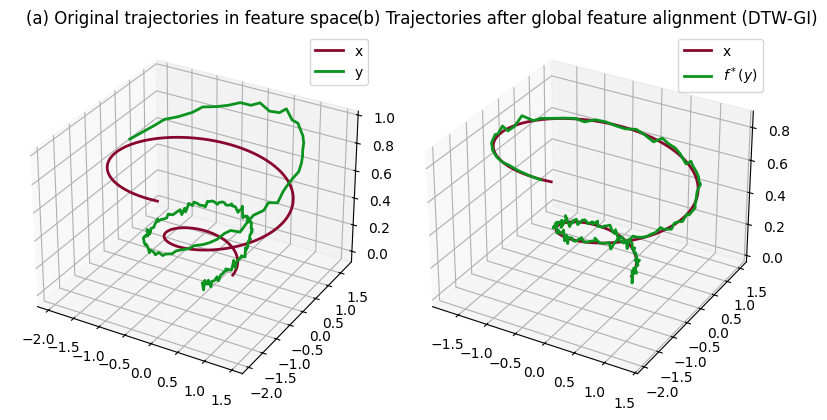

In [11]:
T = 160
theta = np.linspace(0.2, 3.5 * np.pi, T)   

a, b = 0.3, 0.15
c = 0.08

r = a + b * theta

x = np.stack([
    r * np.cos(theta),
    r * np.sin(theta),
    c * theta
], axis=1)


s = np.linspace(0, 1, T)

tau = np.clip(
    s**1.35 + 0.07 * np.sin(2 * np.pi * s),
    0, 1
)

theta_tau = 0.2 + tau * (3.5 * np.pi - 0.2)
r_tau = a + b * theta_tau


y = np.stack([
    r_tau * np.cos(theta_tau),
    r_tau * np.sin(theta_tau),
    c * theta_tau
], axis=1)


def random_rotation_3d(seed=0):
    rng = np.random.default_rng(seed)
    A = rng.normal(size=(3, 3))
    Q, _ = np.linalg.qr(A)
    return Q

R = random_rotation_3d(seed=42)

y = (R @ y.T).T + 0.015 * np.random.randn(*y.shape)


res = dtw_gi(x, y)

P = res.P
path = res.path

y_aligned = (P @ y.T).T
W = path_to_W(path, len(x), len(y))

x_corr = np.array([x[i] for i, j in path])
y_corr = np.array([y[j] for i, j in path])

step = max(len(path) // 40, 1)  
idx = np.arange(0, len(path), step)

x_corr = x_corr[idx]
y_corr = y_corr[idx]



from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(*x.T, lw=2, label="x", color= "#87072d")
ax1.plot(*y.T, lw=2, label="y", color =   "#0B931F")
ax1.set_title("(a) Original trajectories in feature space")
ax1.legend()

ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(*x.T, lw=2, label="x", color = "#87072d")
ax2.plot(*y_aligned.T, lw=2, label=r"$f^*(y)$", color = "#0B931F")
ax2.set_title("(b) Trajectories after global feature alignment (DTW-GI)")
ax2.legend()



plt.tight_layout()
plt.show()


### Temporal Correspondance Analysis

#### *Utility plot functions*

In [17]:
def path_to_pairs(path):
    # path is list[(i,j)] or np array shape (L,2)
    return list(map(tuple, path))

def plot_correspondences_2d(
    ax,
    X2,
    Y2,
    path,
    title,
    cmap_name="turbo",
    y_offset=None,
    line_alpha_same=0.75,
    line_alpha_diff=0.45,
    lw_same=1.25,
    lw_diff=1.0,
    s_point=35,
    s_ring=38,
    ring_lw=1.0,
    add_grid=True,
):
    """
    Plot X2 and Y2 (T x 2 each) with Y translated downward, then draw alignment lines.
    - Points are colored by time index (rainbow-like via cmap).
    - Dark rings show exact time-steps.
    - Lines: green if i==j else red.
    - Grid is drawn in the background (even though axes are hidden).
    """
    path = path_to_pairs(path)

    Tx = X2.shape[0]
    Ty = Y2.shape[0]

    # translate Y downward to separate the curves
    if y_offset is None:
        y_span = max(np.ptp(X2[:, 1]), np.ptp(Y2[:, 1]))
        y_offset = 1.35 * (y_span if y_span > 1e-9 else 1.0)

    Y2_shift = Y2.copy()
    Y2_shift[:, 1] -= y_offset

    # time colors
    cmap = plt.get_cmap(cmap_name)
    cx = np.linspace(0, 1, Tx)
    cy = np.linspace(0, 1, Ty)

    # ---- set limits early so grid can be placed nicely
    all_x = np.concatenate([X2[:, 0], Y2_shift[:, 0]])
    all_y = np.concatenate([X2[:, 1], Y2_shift[:, 1]])
    pad_x = 0.08 * (all_x.max() - all_x.min() + 1e-9)
    pad_y = 0.08 * (all_y.max() - all_y.min() + 1e-9)

    ax.set_xlim(all_x.min() - pad_x, all_x.max() + pad_x)
    ax.set_ylim(all_y.min() - pad_y, all_y.max() + pad_y)

    # ---- grid (background)
    if add_grid:
        ax.set_axisbelow(True)
        ax.grid(True, which="major", linewidth=0.6, alpha=0.25)
        ax.minorticks_on()
        ax.grid(True, which="minor", linewidth=0.4, alpha=0.12)

    # trajectories (thin)
    ax.plot(X2[:, 0], X2[:, 1], lw=1.4)
    ax.plot(Y2_shift[:, 0], Y2_shift[:, 1], lw=1.4)

    # colored points + dark ring overlay
    ax.scatter(X2[:, 0], X2[:, 1], c=cx, cmap=cmap, s=s_point, zorder=3)
    ax.scatter(X2[:, 0], X2[:, 1], s=s_ring, facecolors="none",
               edgecolors="#111111", linewidths=ring_lw, zorder=4)

    ax.scatter(Y2_shift[:, 0], Y2_shift[:, 1], c=cy, cmap=cmap, s=s_point, zorder=3)
    ax.scatter(Y2_shift[:, 0], Y2_shift[:, 1], s=s_ring, facecolors="none",
               edgecolors="#111111", linewidths=ring_lw, zorder=4)

    # alignment lines
    for (i, j) in path:
        xi = X2[i]
        yj = Y2_shift[j]

        if i == j:
            col = "#037F2C"  # green
            alpha = line_alpha_same
            lw = lw_same
        else:
            col = "#D90202"  # red
            alpha = line_alpha_diff
            lw = lw_diff

        ax.plot([xi[0], yj[0]], [xi[1], yj[1]], color=col, alpha=alpha, lw=lw, zorder=2)

    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")

    # keep grid but remove spines/ticks labels
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


[Multi-start DTW-GI] identity cost = 0.000185
[Multi-start DTW-GI] random 1/5 cost = 0.000201
[Multi-start DTW-GI] random 2/5 cost = 0.000185
[Multi-start DTW-GI] random 3/5 cost = 0.000185
[Multi-start DTW-GI] random 4/5 cost = 0.000185
[Multi-start DTW-GI] random 5/5 cost = 0.000185
[Multi-start DTW-GI] selected cost = 0.000185 (n_iter=200)


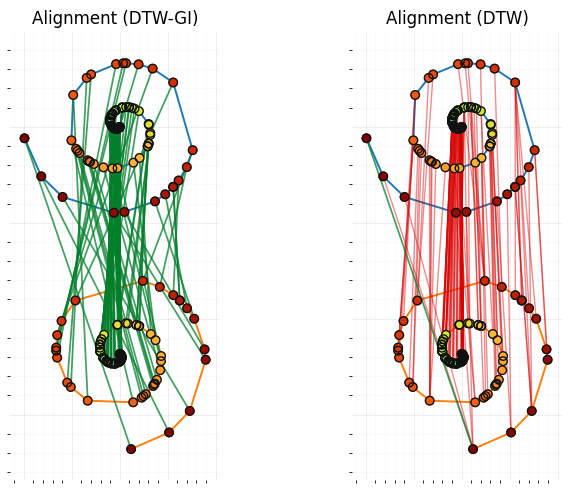

In [18]:
def make_one_spiral(sz, noise=.5):
    uniform_in_01 = np.random.rand(sz, 1)
    non_uniform_in_01 = np.power(uniform_in_01, 4)
    n = np.sqrt(non_uniform_in_01) * 780 * (2 * np.pi) / 360
    n = np.sort(n.reshape((-1, ))).reshape((-1, 1))
    d1x = -np.cos(n) * n + np.random.rand(sz, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(sz, 1) * noise
    arr = np.array(np.hstack((d1x, d1y)))
    return arr / np.max(n)



def get_rot2d(theta):
    return np.array(
        [[np.cos(theta), -np.sin(theta)],
         [np.sin(theta), np.cos(theta)]]
    )


x = make_one_spiral(sz=100, noise=0.0)
R1 = get_rot2d(np.pi / 3)
trajectory = x @ R1.T
rng = np.random.default_rng(0)
R = get_rot2d(np.pi/2)
y = trajectory @ R.T + 0.001 * rng.standard_normal(x.shape)

rotated_trajectory = y

path_dtw, _ = dtw_path(trajectory, rotated_trajectory)

path_gi = dtw_gi_multistart(trajectory, rotated_trajectory, max_iter=200, verbose = True).path

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

plot_correspondences_2d(
    axes[0], trajectory, rotated_trajectory, path_gi,
    title="Alignment (DTW-GI)",
    cmap_name="turbo"
)

plot_correspondences_2d(
    axes[1], trajectory, rotated_trajectory, path_dtw,
    title="Alignment (DTW)",
    cmap_name="turbo"
)

plt.tight_layout()
plt.show()

## *Rotation Invariance*

### Distance vs Rotation Angle

In [19]:
def set_fig_style(font_size=18):
    from matplotlib import rc
    rc('font', family='serif', size=font_size)

T = 80
noise_std = 0.01
angles = np.linspace(0.0, 2 * np.pi, 30)
n_runs = 15

set_fig_style(font_size=14)

np.random.seed(0)


# Storage
dtw_costs = np.zeros((n_runs, len(angles)))
gi_costs = np.zeros((n_runs, len(angles)))
soft_gi_costs = np.zeros((n_runs, len(angles)))


# Main loop
for run in range(n_runs):
    # Fresh reference signal each run
    x = make_one_spiral(T, noise=noise_std)

    # Sweep angles
    for j, alpha in enumerate(angles):
        y = make_one_spiral(T, noise=noise_std)
        y = np.dot(y, get_rot2d(alpha))

        # DTW
        path, cost_dtw = compute_dtw_path(x, y)
        dtw_costs[run, j] = cost_dtw

        # DTW-GI
        res_gi = dtw_gi(
            x, y, max_iter=30
        )
        gi_costs[run, j] = res_gi.cost

        # softDTW-GI
        soft_cost = np.sqrt(soft_dtw_gi(
            x, y,
            gamma=0.01,
            max_iter=150,
            lr=0.01,
            normalize =True
        ).cost)
        soft_gi_costs[run, j] = soft_cost

        print(
        f"alpha={alpha:.2f} | "
        f"DTW={cost_dtw:.3f} | "
        f"DTW-GI={res_gi.cost:.3f} | "
        f"SoftDTW-GI={soft_cost:.3f}"
    )

    print(f"[Run {run+1:02d}/{n_runs}] completed")

alpha=0.00 | DTW=0.590 | DTW-GI=0.590 | SoftDTW-GI=0.808
alpha=0.22 | DTW=0.803 | DTW-GI=0.719 | SoftDTW-GI=0.792
alpha=0.43 | DTW=1.026 | DTW-GI=0.909 | SoftDTW-GI=0.793
alpha=0.65 | DTW=2.318 | DTW-GI=0.924 | SoftDTW-GI=1.003
alpha=0.87 | DTW=3.178 | DTW-GI=0.409 | SoftDTW-GI=0.707
alpha=1.08 | DTW=4.212 | DTW-GI=0.687 | SoftDTW-GI=0.908
alpha=1.30 | DTW=2.751 | DTW-GI=1.167 | SoftDTW-GI=1.153
alpha=1.52 | DTW=6.977 | DTW-GI=0.959 | SoftDTW-GI=0.994
alpha=1.73 | DTW=11.550 | DTW-GI=0.953 | SoftDTW-GI=0.861
alpha=1.95 | DTW=10.050 | DTW-GI=0.808 | SoftDTW-GI=0.936
alpha=2.17 | DTW=18.978 | DTW-GI=1.328 | SoftDTW-GI=1.191
alpha=2.38 | DTW=22.656 | DTW-GI=0.579 | SoftDTW-GI=0.689
alpha=2.60 | DTW=13.195 | DTW-GI=0.552 | SoftDTW-GI=0.801
alpha=2.82 | DTW=19.139 | DTW-GI=1.334 | SoftDTW-GI=1.176
alpha=3.03 | DTW=22.419 | DTW-GI=0.586 | SoftDTW-GI=0.835
alpha=3.25 | DTW=4.625 | DTW-GI=2.441 | SoftDTW-GI=1.451
alpha=3.47 | DTW=19.653 | DTW-GI=1.495 | SoftDTW-GI=1.263
alpha=3.68 | DTW=24.424

In [20]:
# Normalization
dtw_mean = dtw_costs[:13,:].mean(axis=0)
gi_mean = gi_costs[:13,:].mean(axis=0)
soft_gi_mean = soft_gi_costs[:13,:].mean(axis=0)

dtw_mean /= dtw_mean[0]
gi_mean /= gi_mean[0]
soft_gi_mean /= soft_gi_mean[0]

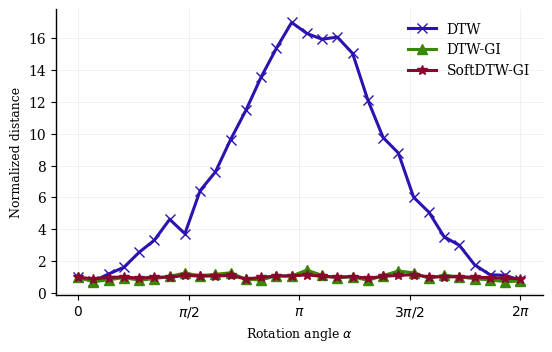

In [22]:
plt.rcParams.update({
    "savefig.dpi": 100,
    "figure.dpi": 100,
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.0,
})

fig, ax = plt.subplots(figsize=(5.4, 3.4))  

ax.plot(
    angles,
    dtw_mean,
    color="#2b13af",
    linewidth=2.2,
    marker="x",
    markersize=7,
    label="DTW",
)

ax.plot(
    angles,
    gi_mean,
    color="#3a8707",
    linewidth=2.2,
    marker="^",
    markersize=7,
    label="DTW-GI",
)

ax.plot(
    angles,
    soft_gi_mean,
    color="#87072d",
    linewidth=2.2,
    marker="*",
    markersize=7,
    label="SoftDTW-GI",
)

ax.set_xlabel(r"Rotation angle $\alpha$")
ax.set_ylabel("Normalized distance")

ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(
    [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
)

ax.grid(True, alpha=0.2, linewidth=0.6)
ax.legend(frameon=False, loc="upper right")

plt.tight_layout(pad=0.3)
plt.show()


## *Barycenter Experiments*

### Barycenter formulation under softDTW-GI

In [17]:
def softdtw_gi_barycenter(
    dataset: List[np.ndarray],
    T: int,
    p: int,
    *,
    gamma: float = 1.0,
    max_iter: int = 20,
    lr_b: float = 1e-2,
    early_stopping_patience: int | None = 5,
    verbose: bool = True,
) -> np.ndarray:
    """
    Compute a softDTW-GI barycenter of a dataset of time series.

    Parameters
    ----------
    dataset : list of (T_i, p_x) arrays
        Input time series.
    T : int
        Length of the barycenter.
    p : int
        Dimension of the barycenter.
    gamma : float
        softDTW smoothing parameter.
    max_iter : int
        Maximum number of iterations.
    lr_b : float
        Learning rate for barycenter update.
    early_stopping_patience : int or None
        Early stopping patience.
    verbose : bool
        Print optimization progress.

    Returns
    -------
    b : (T, p) ndarray
        Estimated barycenter.
    """

    n_series = len(dataset)
    px = dataset[0].shape[1]

    # initialization
    b = np.mean(dataset, axis=0)[:T, :p]
    Ps = [project_to_stiefel(np.eye(px, p)) for _ in dataset]

    best_loss = np.inf
    best_iter = -1

    for it in range(1, max_iter + 1):

        # --- update each P_i
        for i, x_i in enumerate(dataset):
            P = Ps[i]
            eps = 1e-6
            G = np.zeros_like(P)

            loss = normalized_softdtw(
                x_i, apply_linear_map(b, P), gamma
            )

            for a in range(P.shape[0]):
                for b_idx in range(P.shape[1]):
                    P_pert = P.copy()
                    P_pert[a, b_idx] += eps
                    P_pert = project_to_stiefel(P_pert)

                    loss_pert = normalized_softdtw(
                        x_i,
                        apply_linear_map(b, P_pert),
                        gamma,
                    )
                    G[a, b_idx] = (loss_pert - loss) / eps

            Ps[i] = project_to_stiefel(P - 1e-2 * G)

        # --- update barycenter b
        grad_b = np.zeros_like(b)

        for i, x_i in enumerate(dataset):
            P = Ps[i]
            eps = 1e-6

            loss = normalized_softdtw(
                x_i, apply_linear_map(b, P), gamma
            )

            for t in range(T):
                for d in range(p):
                    b_pert = b.copy()
                    b_pert[t, d] += eps

                    loss_pert = normalized_softdtw(
                        x_i,
                        apply_linear_map(b_pert, P),
                        gamma,
                    )
                    grad_b[t, d] += (loss_pert - loss) / eps

        grad_b /= n_series
        b -= lr_b * grad_b

        # --- bookkeeping
        total_loss = np.mean([
            normalized_softdtw(
                x_i, apply_linear_map(b, Ps[i]), gamma
            )
            for i, x_i in enumerate(dataset)
        ])

        if verbose:
            print(
                f"[softDTW-GI barycenter] iter={it:03d} | "
                f"loss={total_loss:.6f}"
            )

        if total_loss < best_loss:
            best_loss = total_loss
            best_iter = it
        elif (
            early_stopping_patience is not None
            and (it - best_iter) > early_stopping_patience
        ):
            if verbose:
                print(f"[softDTW-GI barycenter] early stop @ iter={it:03d}")
            break

    return b


### The following code that computes the barycenter under DTW-GI was *directly* taken from the authors' source code

In [20]:
"""
Code directly taken from rtavear's git repository
"""

import numpy
import torch
import torch.optim as optim
import geoopt
import warnings
from scipy.interpolate import interp1d
from sklearn.exceptions import ConvergenceWarning
from tslearn.utils import to_time_series, ts_size
from tslearn.metrics import dtw_path
import scipy

def path2mat(path):
    max0, max1 = path[-1]
    w_pi = np.zeros((max0 + 1, max1 + 1))
    for i, j in path:
        w_pi[i, j] = 1.
    return w_pi

EPSILON = 1e-6

def dtw_gi(ts0, ts1, init_p=None, max_iter=20, return_matrix=False,
           verbose=False, use_bias=False):
    r"""Compute Dynamic Time Warping with Global Invariance (DTW-GI) similarity
    measure between (possibly multidimensional) time series and return it.
    DTW-GI is computed as the Euclidean distance between aligned+rotated time
    series, i.e.:

    .. math::
        DTW-GI(X, Y) = \min_{P \in V_{d_0, d_1}} \min_{\Pi}
                        \sqrt{\sum_{(i, j) \in \Pi} \|X_{i} - Y_{j} P^T \|^2}
        
    It is not required that both time series share the same size, nor the same 
    dimension. DTW was originally presented in [1]_.
    
    Parameters
    ----------
    ts0: array of shape (sz0, d0)
        A time series.
        
    ts1: array of shape (sz1, d1)
        A time series.
        
    init_p : array of shape (d0, d1) (default: None)
        Initial p matrix for the Stiefel linear map. If None, identity matrix
        is used.
        
    max_iter : int (default: 20)
        Number of iterations for the iterative optimization algorithm.
    
    return_matrix : boolean (default: False)
        Whether the warping matrix should be returned in place of the path.
    
    verbose: boolean (default: True)
        Whether information should be printed during optimization

    use_bias: boolean (default: False)
        If True, the feature space map is affine, otherwise it is linear.
        
    Returns
    -------
    w_pi or path
        Warping matrix (binary matrix of shape (sz0, sz1) or path (list of
        index pairs)
        
    p
        Stiefel matrix
        
    cost
        Similarity score
    
    References
    ----------
    .. [1] H. Sakoe, S. Chiba, "Dynamic programming algorithm optimization for
           spoken word recognition," IEEE Transactions on Acoustics, Speech and
           Signal Processing, vol. 26(1), pp. 43--49, 1978.
    """
    ts0_ = to_time_series(ts0, remove_nans=True)
    ts1_ = to_time_series(ts1, remove_nans=True)

    sz0, d0 = ts0_.shape
    sz1, d1 = ts1_.shape

    ts0_m = ts0_.mean(axis=0).reshape((-1, 1))
    ts1_m = ts1_.mean(axis=0).reshape((-1, 1))

    w_pi = np.zeros((sz0, sz1))
    if init_p is None:
        p = np.eye(d0, d1)
    else:
        p = init_p
    bias = np.zeros((d0, 1))

    # BCD loop
    for iter in range(1, max_iter + 1):
        w_pi_old = w_pi
        # Temporal alignment
        path, cost = dtw_path(ts0_, ts1_.dot(p.T) + bias.T)
        if verbose:
            print("Iteration {}: DTW cost: {:.3f}".format(iter, cost))
        w_pi = path2mat(path)
        if np.allclose(w_pi, w_pi_old):
            break
        # Feature space registration
        if use_bias:
            m = (ts0_.T - ts0_m).dot(w_pi).dot(ts1_ - ts1_m.T)
        else:
            m = (ts0_.T).dot(w_pi).dot(ts1_)
        u, sigma, vt = scipy.linalg.svd(m, full_matrices=False)
        p = u.dot(vt)
        if use_bias:
            bias = ts0_m - ts1_m.T.dot(p.T).T
    path, cost = dtw_path(ts0_, ts1_.dot(p.T) + bias.T)
    if verbose:
        print("After optimization: DTW cost: {:.3f}".format(cost))
    if use_bias:
        if return_matrix:
            return w_pi, p, bias, cost
        else:
            return path, p, bias, cost
    else:
        if return_matrix:
            return w_pi, p, cost
        else:
            return path, p, cost
        

def dtw_gi_barycenter_averaging(X, barycenter_size=None,
                                init_barycenter=None,
                                max_iter=30, tol=1e-5, weights=None,
                                metric_params=None,
                                keep_p_matrices=False,
                                verbose=False, n_init=3):
    """DTW-GI Barycenter Averaging (DBA) method estimated through
    Expectation-Maximization algorithm.

    DBA was originally presented in [1]_.
    This implementation is based on a idea from [2]_ (Majorize-Minimize Mean
    Algorithm).

    Parameters
    ----------
    X : array-like, shape=(n_ts, sz, d)
        Time series dataset.

    barycenter_size : int or None (default: None)
        Size of the barycenter to generate. If None, the size of the barycenter
        is that of the data provided at fit
        time or that of the initial barycenter if specified.

    init_barycenter : array or None (default: None)
        Initial barycenter to start from for the optimization process.

    max_iter : int (default: 30)
        Number of iterations of the Expectation-Maximization optimization
        procedure.

    tol : float (default: 1e-5)
        Tolerance to use for early stopping: if the decrease in cost is lower
        than this value, the
        Expectation-Maximization procedure stops.

    weights: None or array
        Weights of each X[i]. Must be the same size as len(X).
        If None, uniform weights are used.

    metric_params: dict or None (default: None)
        DTW constraint parameters to be used.
        See :ref:`tslearn.metrics.dtw_path <fun-tslearn.metrics.dtw_path>` for
        a list of accepted parameters
        If None, no constraint is used for DTW computations.

    keep_p_matrices: bool (default: False)
        Whether P matrices from previous iteration should be used to initialize
        P matrices for the current iteration

    verbose : boolean (default: False)
        Whether to print information about the cost at each iteration or not.

    n_init : int (default: 3)
        Number of different initializations to try

    Returns
    -------
    numpy.array of shape (barycenter_size, d) or (sz, d) if barycenter_size \
            is None
        DBA barycenter of the provided time series dataset.

    float
        Corresponding cost (weighted sum of alignement costs)

    References
    ----------
    .. [1] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method
       for dynamic time warping, with applications to clustering. Pattern
       Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693

    .. [2] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    best_cost = numpy.inf
    best_barycenter = None
    for i in range(n_init):
        if verbose:
            print("Attempt {}".format(i + 1))
        bary, loss = dtw_gi_barycenter_averaging_one_init(
            X=X,
            barycenter_size=barycenter_size,
            init_barycenter=init_barycenter,
            max_iter=max_iter,
            tol=tol,
            weights=weights,
            metric_params=metric_params,
            keep_p_matrices=keep_p_matrices,
            verbose=verbose
        )
        if loss < best_cost:
            best_cost = loss
            best_barycenter = bary
    return best_barycenter, best_cost


def dtw_gi_barycenter_averaging_one_init(X, barycenter_size=None,
                                         init_barycenter=None,
                                         max_iter=30, tol=1e-5, weights=None,
                                         metric_params=None,
                                         keep_p_matrices=False,
                                         verbose=False):
    """DTW-GI Barycenter Averaging (DBA) method estimated through
    Expectation-Maximization algorithm.

    DBA was originally presented in [1]_.
    This implementation is based on a idea from [2]_ (Majorize-Minimize Mean
    Algorithm).

    Here, the transform is of the form x -> Ax + b where A lies on the Stiefel
    manifold.

    Parameters
    ----------
    X : array-like, shape=(n_ts, sz, d)
        Time series dataset.

    barycenter_size : int or None (default: None)
        Size of the barycenter to generate. If None, the size of the barycenter
        is that of the data provided at fit
        time or that of the initial barycenter if specified.

    init_barycenter : array or None (default: None)
        Initial barycenter to start from for the optimization process.

    max_iter : int (default: 30)
        Number of iterations of the Expectation-Maximization optimization
        procedure.

    tol : float (default: 1e-5)
        Tolerance to use for early stopping: if the decrease in cost is lower
        than this value, the
        Expectation-Maximization procedure stops.

    weights: None or array
        Weights of each X[i]. Must be the same size as len(X).
        If None, uniform weights are used.

    metric_params: dict or None (default: None)
        DTW constraint parameters to be used.
        See :ref:`tslearn.metrics.dtw_path <fun-tslearn.metrics.dtw_path>` for
        a list of accepted parameters
        If None, no constraint is used for DTW computations.

    keep_p_matrices: bool (default: False)
        Whether P matrices from previous iteration should be used to initialize
        P matrices for the current iteration

    verbose : boolean (default: False)
        Whether to print information about the cost at each iteration or not.

    Returns
    -------
    numpy.array of shape (barycenter_size, d) or (sz, d) if barycenter_size \
            is None
        DBA barycenter of the provided time series dataset.

    float
        Corresponding cost (weighted sum of alignement costs)

    References
    ----------
    .. [1] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method
       for dynamic time warping, with applications to clustering. Pattern
       Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693

    .. [2] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    X_ = [to_time_series(Xi, remove_nans=True) for Xi in X]
    if barycenter_size is None:
        barycenter_size = ts_size(X_[0])
    weights = _set_weights(weights, len(X_))
    if init_barycenter is None:
        try:
            barycenter = _init_avg(X_, barycenter_size)
        except:
            barycenter_idx = numpy.random.choice(len(X_))
            barycenter = X_[barycenter_idx]
    else:
        barycenter = init_barycenter
    cost_prev, cost = numpy.inf, numpy.inf
    list_p = [numpy.eye(Xi.shape[1], barycenter.shape[1]).T for Xi in X_]
    for it in range(max_iter):
        if not keep_p_matrices:
            list_p = None
        list_w_pi, list_p, list_bias, cost = _mm_assignment(
            X_,
            barycenter,
            weights,
            list_init_p=list_p,
            metric_params=metric_params
        )
        diag_sum_v_k, list_w_k = _mm_valence_warping(list_w_pi, weights)
        if verbose:
            print("[DBA] epoch %d, cost: %.3f" % (it + 1, cost))
        rotated_x = [numpy.empty(Xi.shape) for Xi in X_]
        for i in range(len(X_)):
            rotated_x[i] = X_[i].dot(list_p[i].T) + list_bias[i].T
        barycenter = _mm_update_barycenter(rotated_x, diag_sum_v_k, list_w_k)
        if abs(cost_prev - cost) < tol:
            break
        elif cost_prev < cost:
            warnings.warn("DBA loss is increasing while it should not be. "
                          "Stopping optimization.", ConvergenceWarning)
            break
        else:
            cost_prev = cost
    return barycenter, cost


def _set_weights(w, n):
    """Return w if it is a valid weight vector of size n, and a vector of n 1s
    otherwise.
    """
    if w is None or len(w) != n:
        w = numpy.ones((n,))
    return w


def _init_avg(X, barycenter_size):
    if ts_size(X[0]) == barycenter_size:
        return numpy.nanmean(X, axis=0)
    else:
        X_avg = numpy.nanmean(X, axis=0)
        xnew = numpy.linspace(0, 1, barycenter_size)
        f = interp1d(numpy.linspace(0, 1, X_avg.shape[0]), X_avg,
                     kind="linear", axis=0)
        return f(xnew)


def _mm_assignment(X, barycenter, weights, list_init_p=None,
                   metric_params=None):
    """Computes item assignement based on DTW alignments and return cost as a
    bonus.

    Parameters
    ----------
    X : numpy.array of shape (n, sz, d)
        Time-series to be averaged

    barycenter : numpy.array of shape (barycenter_size, d)
        Barycenter as computed at the current step of the algorithm.

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    list_init_p: list of arrays of shape (d, d)
        Initial P matrices

    metric_params: dict or None (default: None)
        Key-value parameters for f_dtw

    Returns
    -------
    list_W_pi
        List of warping matrices

    list_p
        List of mapping matrices

    float
        Current alignment cost
    """
    if metric_params is None:
        metric_params = {}
    n = len(X)
    if list_init_p is None:
        list_init_p = [numpy.eye(Xi.shape[1], barycenter.shape[1]).T
                       for Xi in X]
    cost = 0.
    list_w_pi = []
    list_p = []
    list_bias = []
    for i in range(n):
        w_pi, p_i, bias_i, dist_i = dtw_gi(barycenter, X[i],
                                           init_p=list_init_p[i],
                                           return_matrix=True,
                                           use_bias=True,
                                           **metric_params)
        cost += dist_i ** 2 * weights[i]
        list_w_pi.append(w_pi)
        list_p.append(p_i)
        list_bias.append(bias_i)
    cost /= weights.sum()
    return list_w_pi, list_p, list_bias, cost


def _subgradient_valence_warping(list_w_pi, weights):
    """Compute Valence and Warping matrices from paths.

    Valence matrices are denoted :math:`V^{(k)}` and Warping matrices are
    :math:`W^{(k)}` in [1]_.

    This function returns a list of :math:`V^{(k)}` diagonals (as a vector)
    and a list of :math:`W^{(k)}` matrices.

    Parameters
    ----------
    list_w_pi : list of arrays of shape (sz_bar, sz_i)
        List of warping matrices

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    Returns
    -------
    list of numpy.array of shape (barycenter_size, )
        list of weighted :math:`V^{(k)}` diagonals (as a vector)

    list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    list_v_k = []
    list_w_k = []
    for k, w_pi in enumerate(list_w_pi):
        list_w_k.append(w_pi * weights[k])
        list_v_k.append(w_pi.sum(axis=1) * weights[k])
    return list_v_k, list_w_k


def _mm_valence_warping(list_w_pi, weights):
    """Compute Valence and Warping matrices from paths.

    Valence matrices are denoted :math:`V^{(k)}` and Warping matrices are
    :math:`W^{(k)}` in [1]_.

    This function returns the sum of :math:`V^{(k)}` diagonals (as a vector)
    and a list of :math:`W^{(k)}` matrices.

    Parameters
    ----------
    list_w_pi : list of arrays of shape (sz_bar, sz_i)
        list of Warping matrices

    barycenter_size : int
        Size of the barycenter to generate.

    weights: array
        Weights of each X[i]. Must be the same size as len(X).

    Returns
    -------
    numpy.array of shape (barycenter_size, )
        sum of weighted :math:`V^{(k)}` diagonals (as a vector)

    list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    list_v_k, list_w_k = _subgradient_valence_warping(
        list_w_pi=list_w_pi,
        weights=weights)
    diag_sum_v_k = numpy.zeros(list_v_k[0].shape)
    for v_k in list_v_k:
        diag_sum_v_k += v_k
    return diag_sum_v_k, list_w_k


def _mm_update_barycenter(X, diag_sum_v_k, list_w_k):
    """Update barycenters using the formula from Algorithm 2 in [1]_.

    Parameters
    ----------
    X : numpy.array of shape (n, sz, d)
        Time-series to be averaged

    diag_sum_v_k : numpy.array of shape (barycenter_size, )
        sum of weighted :math:`V^{(k)}` diagonals (as a vector)

    list_w_k : list of numpy.array of shape (barycenter_size, sz_k)
        list of weighted :math:`W^{(k)}` matrices

    Returns
    -------
    numpy.array of shape (barycenter_size, d)
        Updated barycenter

    References
    ----------

    .. [1] D. Schultz and B. Jain. Nonsmooth Analysis and Subgradient Methods
       for Averaging in Dynamic Time Warping Spaces.
       Pattern Recognition, 74, 340-358.
    """
    d = X[0].shape[-1]
    barycenter_size = diag_sum_v_k.shape[0]
    sum_w_x = numpy.zeros((barycenter_size, d))
    for k, (w_k, x_k) in enumerate(zip(list_w_k, X)):
        sum_w_x += w_k.dot(x_k[:ts_size(x_k)])
    barycenter = numpy.diag(1. / diag_sum_v_k).dot(sum_w_x)
    return barycenter


def normalize_tensor(w):
    return w / (torch.norm(w) + EPSILON)


def nanmean(losses):
    s = 0.
    n = 0
    for l in losses:
        if not torch.isnan(l):
            s += l
            n += 1
    return s / n

### Load and Preprocess UJI dataset

In [10]:
def load_uji_word_format(path):
    data = {}
    current_label = None

    with open(path, "r", encoding="latin-1") as f:
        for line in f:
            line = line.strip()

            if not line or line.startswith("//"):
                continue

            if line.startswith("WORD"):
                parts = line.split()
                current_label = parts[1]
                data.setdefault(current_label, [])

            elif line.startswith("POINTS"):
                numbers = line.split("#", 1)[1].strip().split()
                coords = list(map(float, numbers))
                traj = np.array(coords).reshape(-1, 2)
                data[current_label].append(traj)

    return data

In [11]:
PROJECT_ROOT = Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

DATA_PATH = PROJECT_ROOT / "data" / "ujipenchars2.txt"

data = load_uji_word_format(DATA_PATH)

print(sorted(data.keys())[:10])
print(len(data['a']))
print(data['a'][0].shape)

['!', '"', '$', '%', "'", '(', ')', ',', '-', '.']
122
(44, 2)


#### Resample and Normalize/Scale

In [12]:
def resample_trajectory(traj: np.ndarray, T: int) -> np.ndarray:
    """
    Resample a 2D trajectory to T points using arc-length parametrization.
    traj: (N,2)
    returns: (T,2)
    """
    diffs = np.diff(traj, axis=0)
    dists = np.linalg.norm(diffs, axis=1)
    arc = np.concatenate([[0], np.cumsum(dists)])
    arc /= arc[-1]

    new_arc = np.linspace(0, 1, T)
    resampled = np.zeros((T, traj.shape[1]))

    for d in range(traj.shape[1]):
        resampled[:, d] = np.interp(new_arc, arc, traj[:, d])

    return resampled


def normalize_trajectory(traj: np.ndarray) -> np.ndarray:
    """
    Center and scale trajectory.
    """
    traj = traj - traj.mean(axis=0, keepdims=True)
    scale = np.sqrt((traj**2).sum() / traj.shape[0])
    return traj / (scale + 1e-8)



In [ ]:
list_barycenter_functions = [
    lambda dataset, T: dtw_gi_barycenter_averaging(dataset)[0],
                                                    
    lambda dataset, T: softdtw_gi_barycenter(
                                            dataset,
                                            T,
                                            p = 2,
                                            gamma = 0.5,
                                            max_iter = 30,
                                            lr_b= 5e-2,
                                            verbose = False
                                            ),

    lambda dataset, T: dtw_barycenter_averaging(dataset,
                                                barycenter_size= T),
    lambda dataset, T: softdtw_barycenter(dataset,
                                        gamma = 0.5)
                                            
]
list_method_names = ["DTW-GI", "SoftDTW-GI","DTW", "SoftDTW"]

### *Utility plotting function*

In [65]:
def plot_samples_and_barycenters(
    samples,
    results,
    title="Barycenter comparison under rotations",
):
    """
    samples: list of (T, 2) arrays (length = 5)
    results: dict {method_name: barycenter (T,2)}
    """

    n = len(samples)
    T = next(iter(results.values())).shape[0]

    all_curves = samples + list(results.values())
    xs = np.concatenate([c[:, 0] for c in all_curves])
    ys = np.concatenate([c[:, 1] for c in all_curves])

    pad = 0.1
    xlim = (xs.min() - pad, xs.max() + pad)
    ylim = (ys.min() - pad, ys.max() + pad)

    fig, axes = plt.subplots(1, n + len(results), figsize=(18, 3))

    for i, (ax, x) in enumerate(zip(axes[:n], samples)):
        ax.plot(x[:, 0], x[:, 1], lw=2.0, color="0.4")
        ax.set_title(f"sample {i+1}", fontsize=10)
        ax.set_aspect("equal")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.invert_yaxis()
        ax.axis("off")

    colors = {
        "DTW": "#000000",
        "SoftDTW": "#1f77b4",
        "DTW-GI":"#077053",
        "SoftDTW-GI": "#87072d",
    }

    def _plot_bary(ax, bary, title, color):
        t = np.linspace(0, 1, bary.shape[0])
        ax.scatter(
            bary[:, 0],
            bary[:, 1],
            c=t,
            cmap="turbo",
            s=28,
            zorder=3,
        )
        ax.plot(
            bary[:, 0],
            bary[:, 1],
            lw=3.0,
            color=color,
            zorder=4,
        )
        ax.set_title(title, fontsize=10)
        ax.set_aspect("equal")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.invert_yaxis()
        ax.axis("off")

    # --- plot barycenters
    for i, (method, bary) in enumerate(results.items()):
        color = colors.get(method, "black")
        _plot_bary(
            axes[n + i],
            bary,
            f"{method}",
            color,
        )

    fig.suptitle(title, fontsize=13, y=1.05)
    plt.tight_layout()
    plt.show()

## *Experiments on Handwritten Letters (UJI)*

#### **Letter g**

We focus on a single handwritten letter (here, the letter *g*) from the UJI Pen Characters dataset. All trajectories corresponding to this letter are first resampled to a fixed length \(T=50\) and normalized to remove translation and scale effects. This preprocessing ensures temporal comparability and isolates shape information.

To introduce controlled geometric variability, each trajectory is then rotated by a different angle, uniformly spaced in the interval $[-\pi/3, \pi/3]$. This allows us to evaluate the robustness of alignment and barycenter methods to global feature-space transformations.

Finally, a subset of five trajectories is selected at random (with a fixed seed for reproducibility) to be used in subsequent barycenter experiments.

In [67]:
# select letter
letter = 'g'
raw_trajs = data[letter]

T = 50 
dataset = []

for traj in raw_trajs:
    traj_rs = resample_trajectory(traj, T)
    traj_norm = normalize_trajectory(traj_rs)
    dataset.append(traj_norm)

print(len(dataset), dataset[0].shape)  # (n_samples, (T,2))

124 (50, 2)


In [68]:
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)],
    ])

angles = np.linspace(-np.pi / 3, np.pi / 3, len(dataset))

dataset_rot = []
for x, theta in zip(dataset, angles):
    R = rotation_matrix(theta)
    dataset_rot.append(x @ R.T)

rng = np.random.default_rng(seed=42)

idx = rng.choice(len(dataset_rot), size=5, replace=False)
dataset_5 = [dataset_rot[i] for i in idx]

In [69]:
results = {}
for i, (barycenter_fun, title) in enumerate(zip(list_barycenter_functions,
                                                    list_method_names)):
        print(f'Running {title} Barycenter...')
        barycenter = barycenter_fun(dataset_5, T)
        results[title] = barycenter

Running DTW-GI Barycenter...
Running SoftDTW-GI Barycenter...
Running DTW Barycenter...
Running SoftDTW Barycenter...


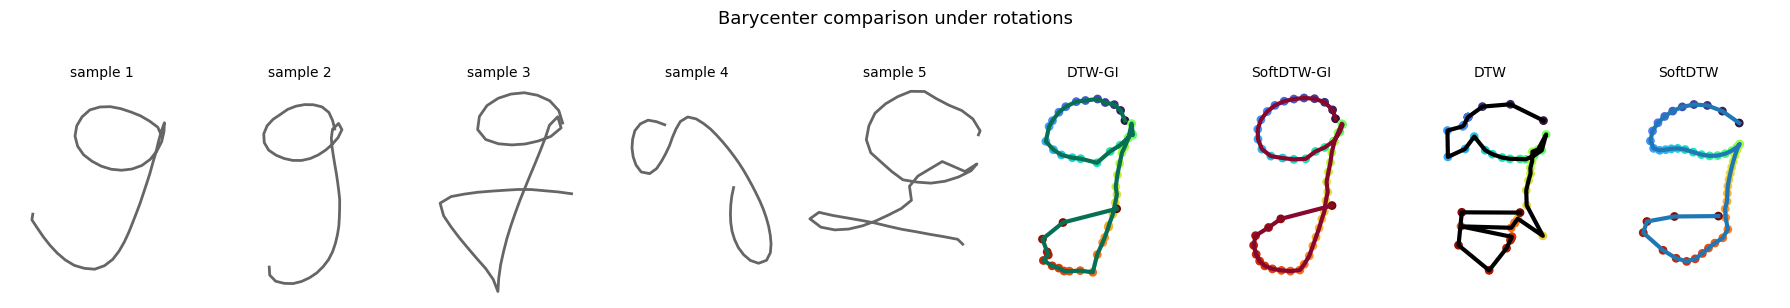

In [70]:
plot_samples_and_barycenters(dataset_5, results)

#### **Letter e**

A subset of five trajectories is randomly selected from the preprocessed dataset of the letter e, using a fixed random seed to ensure reproducibility. To introduce increasing geometric variability, these trajectories are then rotated by progressively larger angles, uniformly spaced between $0$ and $\pi$.

This construction creates a controlled setting in which each sample differs from the others by a known global rotation, allowing us to explicitly evaluate the sensitivity of alignment and barycenter methods to feature-space transformations.

In [58]:
# select letter
letter = 'e'
raw_trajs = data[letter]

T = 50   # very good choice for letters
dataset = []

for traj in raw_trajs:
    traj_rs = resample_trajectory(traj, T)
    traj_norm = normalize_trajectory(traj_rs)
    dataset.append(traj_norm)

print(len(dataset), dataset[0].shape)  # (n_samples, (T,2))

120 (50, 2)


In [59]:
rng = np.random.default_rng(seed=42)

idx = rng.choice(len(dataset), size=5, replace=False)
dataset_rot = [dataset[i] for i in idx]

angles = np.linspace(0, np.pi, len(dataset_rot))

dataset_5 = []
for x, theta in zip(dataset_rot, angles):
    R = rotation_matrix(theta)
    dataset_5.append(x @ R.T)

In [61]:
results = {}
for i, (barycenter_fun, title) in enumerate(zip(list_barycenter_functions,
                                                    list_method_names)):
        print(f'Running {title} Barycenter...')
        barycenter = barycenter_fun(dataset_5, T)
        results[title] = barycenter

Running DTW-GI Barycenter...


C:\Users\halac\AppData\Local\Temp\ipykernel_88584\1475686328.py:335: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "


Running SoftDTW-GI Barycenter...
Running DTW Barycenter...
Running SoftDTW Barycenter...


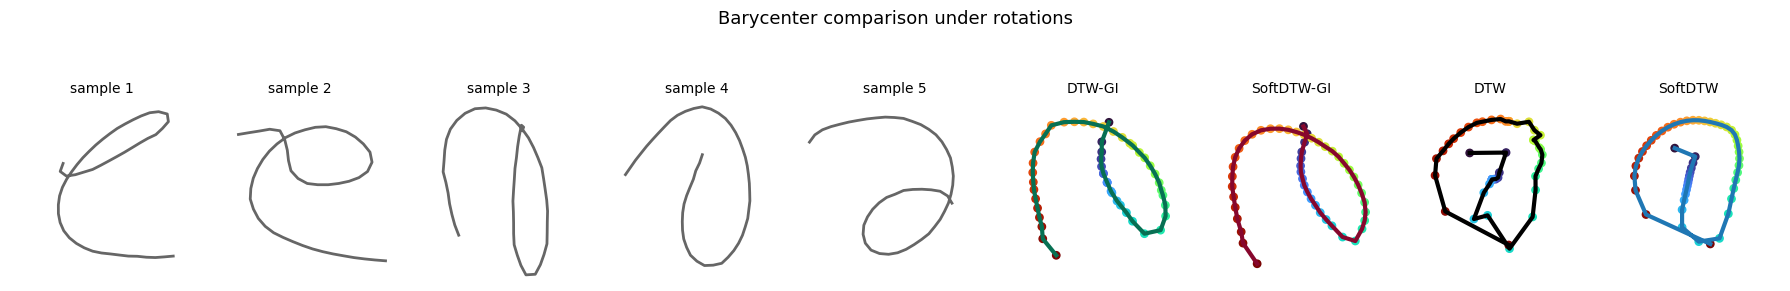

In [66]:
plot_samples_and_barycenters(dataset_5, results)

## *Time Series Forecasting Task: Spatiotemporal forecasting under sensor rotation*

We study short-horizon forecasting on synthetic spatiotemporal signals generated from the two–dimensional linear wave equation,
$$
\partial_{tt} u = c^2 \Delta u,
$$
numerically solved on a $10\times 10$ grid using a second–order explicit finite–difference scheme. Initial conditions consist of a localized Gaussian pulse with random center, and zero initial velocity ($u^1 = u^0$). Periodic boundary conditions are enforced through circular shifts in the discrete Laplacian, producing smooth wave propagation and interference. Each frame is vectorized into $\mathbf{y}_t \in \mathbb{R}^{D}$ with $D=100$.


In [ ]:
GRID_SIZE = 10           # 10x10 Grid
L, H = 50, 50            # Past=50, Future=50
N_LIB = 20               # Training Samples
N_TEST = 5               # Test Samples

In [24]:
# Generating wave data by solving the wave equation iteratively

def solve_wave_pde(nx=10, ny=10, nt=100, velocity=0.5, dt=0.1, dx=1.0):
    u = np.zeros((nt, nx, ny))
    cx, cy = np.random.uniform(nx//4, 3*nx//4, 2)
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    u[0] = np.exp(-((x-cx)**2 + (y-cy)**2) / 2.0)
    u[1] = u[0].copy()
    c_eff = (velocity * dt / dx)**2
    if c_eff > 0.5: velocity = 0.5 
    for t in range(1, nt-1):
        laplacian = (np.roll(u[t], 1, axis=0) + np.roll(u[t], -1, axis=0) +
                     np.roll(u[t], 1, axis=1) + np.roll(u[t], -1, axis=1) - 4*u[t])
        u[t+1] = 2*u[t] - u[t-1] + (velocity * dt / dx)**2 * laplacian
    return u.reshape(nt, -1)


We generate $N_{\text{lib}}=20$ training trajectories and $N_{\text{test}}=5$ test trajectories. To emulate sensor miscalibration, an unknown orthogonal transformation $P\in\mathbb{R}^{100\times100}$ is applied only to the test trajectories, with small Gaussian noise added to the observed past window.


In [ ]:
# Train and test data generation

print("Generating Library...")
p = GRID_SIZE * GRID_SIZE 
X_past_lib, X_fut_lib = [], []
for i in range(N_LIB):
    wave = solve_wave_pde(nx=GRID_SIZE, ny=GRID_SIZE, nt=L+H, velocity=np.random.uniform(0.3, 0.6))
    X_past_lib.append(wave[:L])
    X_fut_lib.append(wave[L:])
X_past_lib = np.stack(X_past_lib)
X_fut_lib = np.stack(X_fut_lib)

print("Generating Test Set with Rotations...")
random_matrix = np.random.randn(p, p)
P_true, _ = np.linalg.qr(random_matrix)
test_waves = []
for i in range(N_TEST):
    wave = solve_wave_pde(nx=GRID_SIZE, ny=GRID_SIZE, nt=L+H, velocity=np.random.uniform(0.3, 0.6))
    y_past = wave[:L] @ P_true.T + 0.002 * np.random.randn(L, p)
    y_true = wave[L:] @ P_true.T
    test_waves.append((y_past, y_true))



 Generating Library...
Generating Test Set with Rotations...


In [26]:
print("Pre-calculating Visualization Matrix P...")

res_viz = dtw_gi(test_waves[0][0], X_past_lib[0], max_iter=10)
P_VIZ = res_viz.P

Pre-calculating Visualization Matrix P...


   > Plotting Ground Truth...


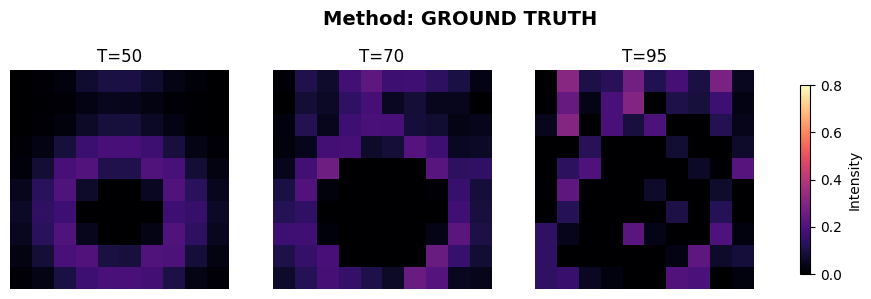

In [27]:
# Visualization utils

def plot_single_method(name, y_hat, y_true, P):
    """ Helper to plot one method immediately """
    t_idx = [0, 20, 45]
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
    
    for i, t in enumerate(t_idx):
        # Un-rotate forecast using P_VIZ
        img = (y_hat[t] @ P).reshape(GRID_SIZE, GRID_SIZE)
        im = axes[i].imshow(img, cmap='magma', vmin=0, vmax=0.8, interpolation='nearest')
        axes[i].set_title(f"T={L+t}")
        axes[i].axis('off')
        
    fig.colorbar(im, ax=axes.ravel().tolist(), label='Intensity', shrink=0.7)
    plt.suptitle(f"Method: {name}", fontsize=14, fontweight='bold')
    plt.show()

# Visualize Truth First
print("   > Plotting Ground Truth...")
plot_single_method("GROUND TRUTH", test_waves[0][1], test_waves[0][1], P_VIZ)


In [28]:
# BENCHMARK
metrics = {}
plot_data = {} # Stores first sample result for the final summary

# Prepare Sklearn Data
y_p_sample, y_t_sample = test_waves[0]
X_train_flat = X_past_lib.reshape(N_LIB, -1)
y_train_flat = X_fut_lib.reshape(N_LIB, -1)
y_test_flat = y_p_sample.reshape(1, -1)


Given the past window $\mathbf{y}_{1:T_0}$ of a test trajectory and a library $\{(\mathbf{x}^{(i)}_{1:T_0},\mathbf{x}^{(i)}_{T_0+1:T})\}_{i=1}^N$, prediction is performed by
$$
\hat{\mathbf{y}}_{T_0+1:T}
=
\sum_{i=1}^N
a_d(\mathbf{y}_{1:T_0},\mathbf{x}^{(i)}_{1:T_0})\,
f_i(\mathbf{x}^{(i)}_{T_0+1:T}),
\quad
a_d(\mathbf{y},\mathbf{x})
=
\frac{e^{-\lambda d(\mathbf{y},\mathbf{x})}}
{\sum_j e^{-\lambda d(\mathbf{y},\mathbf{x}^{(j)})}}.
$$
Here $d$ is instantiated as DTW, DTW-GI, or Soft-DTW-GI. For DTW-GI and Soft-DTW-GI, the transformations $f_i$ are orthogonal matrices estimated on the Stiefel manifold to align spatial coordinates before aggregating futures.

We compare with:
- Persistence, which repeats the last observed frame; 
- Linear Regression, a global linear map from vectorized past to vectorized future; 
- and Random Forest, a nonlinear ensemble regressor trained with the same input–output representation.

Running Persistence...
      MSE: 0.021091


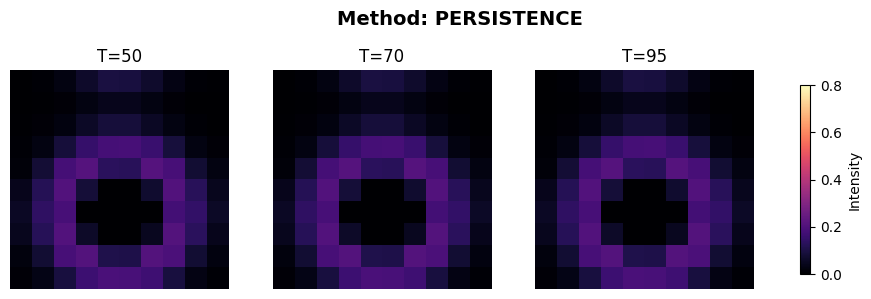

Running Linear Regression ...
      MSE: 0.032799


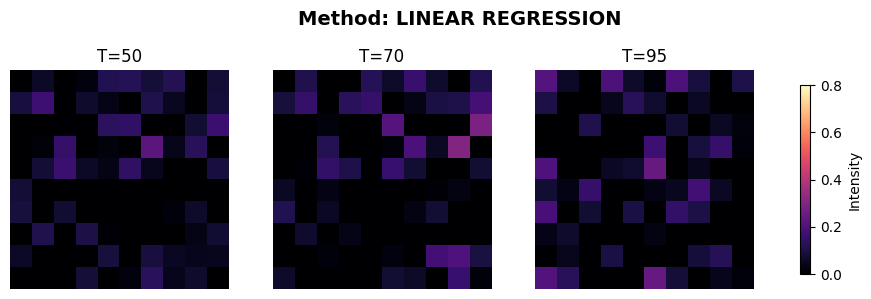

Running Random Forest...
      MSE: 0.022631


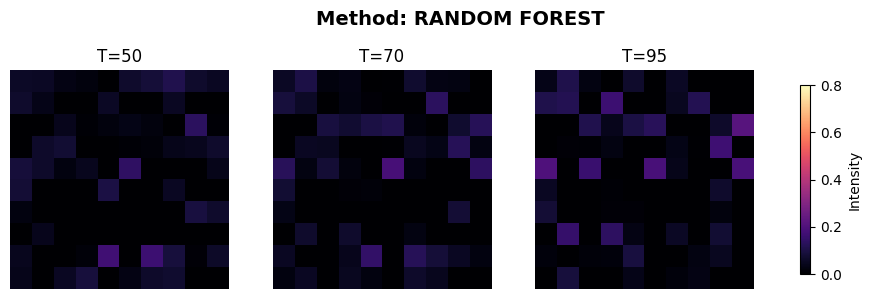


[5/7] Running Standard DTW...
      MSE: 0.035563


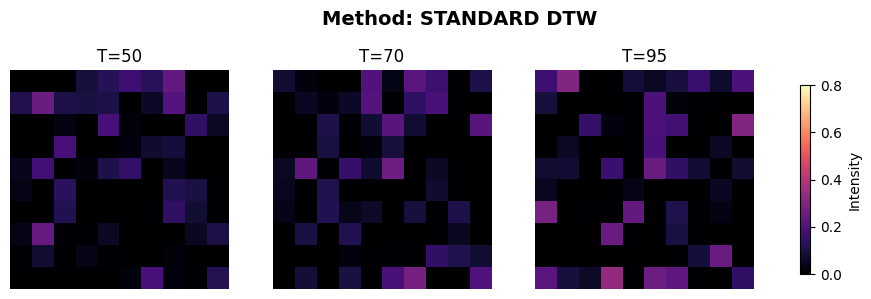

Running DTW-GI (BCD)...
      MSE: 0.005896


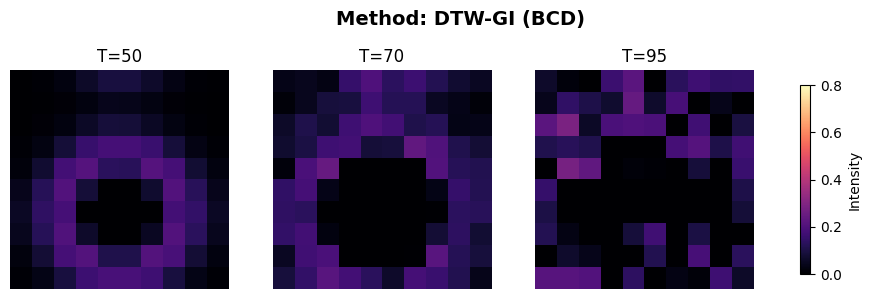

In [38]:
# --- METHOD 1: PERSISTENCE ---
print("Running Persistence...")
y_hat_p = np.tile(y_p_sample[-1], (H, 1))
mse_p = mean_squared_error(y_t_sample, y_hat_p)
metrics["Persistence"] = mse_p
plot_data["Persistence"] = y_hat_p
print(f"      MSE: {mse_p:.6f}")
plot_single_method("PERSISTENCE", y_hat_p, y_t_sample, P_VIZ)

# --- METHOD 2: LINEAR REGRESSION (Global) ---
print("Running Linear Regression ...")
lr = LinearRegression().fit(X_train_flat, y_train_flat)
y_hat_lr = lr.predict(y_test_flat).reshape(H, p)
mse_lr = mean_squared_error(y_t_sample, y_hat_lr)
metrics["Linear Reg"] = mse_lr
plot_data["Linear Reg"] = y_hat_lr
print(f"      MSE: {mse_lr:.6f}")
plot_single_method("LINEAR REGRESSION", y_hat_lr, y_t_sample, P_VIZ)

# --- METHOD 3: RANDOM FOREST ---
print("Running Random Forest...")
rf = RandomForestRegressor(n_estimators=10, max_depth=10).fit(X_train_flat, y_train_flat)
y_hat_rf = rf.predict(y_test_flat).reshape(H, p)
mse_rf = mean_squared_error(y_t_sample, y_hat_rf)
metrics["Random Forest"] = mse_rf
plot_data["Random Forest"] = y_hat_rf
print(f"      MSE: {mse_rf:.6f}")
plot_single_method("RANDOM FOREST", y_hat_rf, y_t_sample, P_VIZ)

# --- METHOD 4: STANDARD DTW ---
print("Running Standard DTW...")
costs_dtw = np.array([np.sum(np.linalg.norm(y_p_sample - X_past_lib[i], axis=1)) for i in range(N_LIB)])
w_dtw = np.exp(-100 * (costs_dtw - np.min(costs_dtw)))
w_dtw /= w_dtw.sum()
y_hat_dtw = np.tensordot(w_dtw, X_fut_lib, axes=(0,0))
mse_dtw = mean_squared_error(y_t_sample, y_hat_dtw)
metrics["DTW"] = mse_dtw
plot_data["DTW"] = y_hat_dtw
print(f"      MSE: {mse_dtw:.6f}")
plot_single_method("STANDARD DTW", y_hat_dtw, y_t_sample, P_VIZ)

# --- METHOD 5: DTW-GI (BCD) ---
print("Running DTW-GI (BCD)...")
costs_bcd, futures_bcd = [], []
for i in range(N_LIB):
    res = dtw_gi(y_p_sample, X_past_lib[i], max_iter=10)
    costs_bcd.append(res.cost)
    futures_bcd.append(apply_linear_map(X_fut_lib[i], res.P))
w_bcd = np.exp(-100 * (np.array(costs_bcd) - np.min(costs_bcd)))
w_bcd /= w_bcd.sum()
y_hat_bcd = np.tensordot(w_bcd, np.stack(futures_bcd), axes=(0,0))
mse_bcd = mean_squared_error(y_t_sample, y_hat_bcd)
metrics["DTW-GI"] = mse_bcd
plot_data["DTW-GI"] = y_hat_bcd
print(f"      MSE: {mse_bcd:.6f}")
plot_single_method("DTW-GI (BCD)", y_hat_bcd, y_t_sample, P_VIZ)

Running Soft-DTW-GI (This one might take some time) ...
      Optimizing on 13 time steps (Factor 4x)...
      Iter 000 | Loss: 71.5608
      Iter 020 | Loss: 7.1590
      Iter 040 | Loss: 7.4101
      Iter 060 | Loss: 4.3678
      Iter 080 | Loss: 5.6899
      Iter 100 | Loss: 7.3473
      Iter 120 | Loss: 6.0747
      Iter 140 | Loss: 7.0840
      Iter 160 | Loss: 4.7824
      Iter 180 | Loss: 4.9443
      Iter 199 | Loss: 8.3650


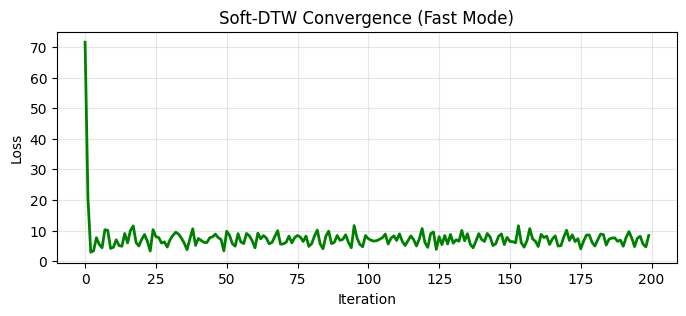

Final Soft-DTW MSE: 0.027854


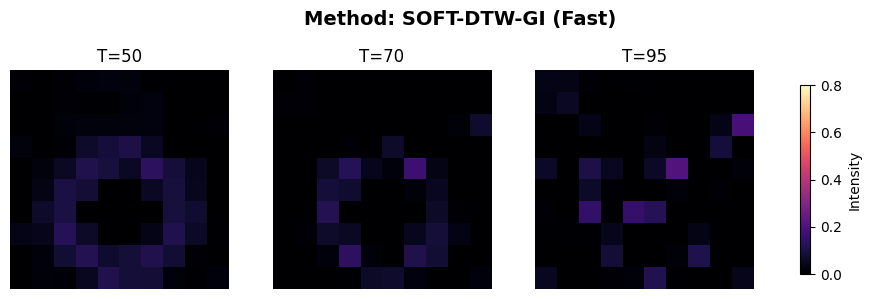

In [ ]:
# --- METHOD 6: SOFT-DTW-GI---
print("Running Soft-DTW-GI (This one might take some time) ...")

try:
    X_lib_gpu = torch.tensor(X_past_lib, dtype=torch.float32, device=DEVICE)
    y_p_sample, y_t_sample = test_waves[0]
    P_batch_np, costs_np, loss_curve = optimize_batch_gi_fast(
        y_p_sample, X_lib_gpu, gamma=2, lr=0.5, max_iter=200, downsample=4
    )
    # Plot Convergence
    plt.figure(figsize=(8, 3))
    plt.plot(loss_curve, color='green', linewidth=2)
    plt.title("Soft-DTW Convergence (Fast Mode)")
    plt.xlabel("Iteration"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.show()

    futures_soft = []
    for i in range(N_LIB):
        futures_soft.append(X_fut_lib[i] @ P_batch_np[i].T)
    c = costs_np
    cmin = c.min()
    s = np.median(c) - cmin
    beta = np.log(len(c)) / (s + 1e-8)

    w_soft = np.exp(-beta * (c - cmin))
    w_soft /= w_soft.sum()

    y_hat_soft = np.tensordot(w_soft, np.stack(futures_soft), axes=(0,0))
    
    # Save Results
    mse_soft = mean_squared_error(y_t_sample, y_hat_soft)
    metrics["Soft-DTW-GI"] = mse_soft
    plot_data["Soft-DTW-GI"] = y_hat_soft
    print(f"Final Soft-DTW MSE: {mse_soft:.6f}")    
    plot_single_method("SOFT-DTW-GI", y_hat_soft, y_t_sample, P_VIZ)

except Exception as e:
    print(f"Error: {e}")


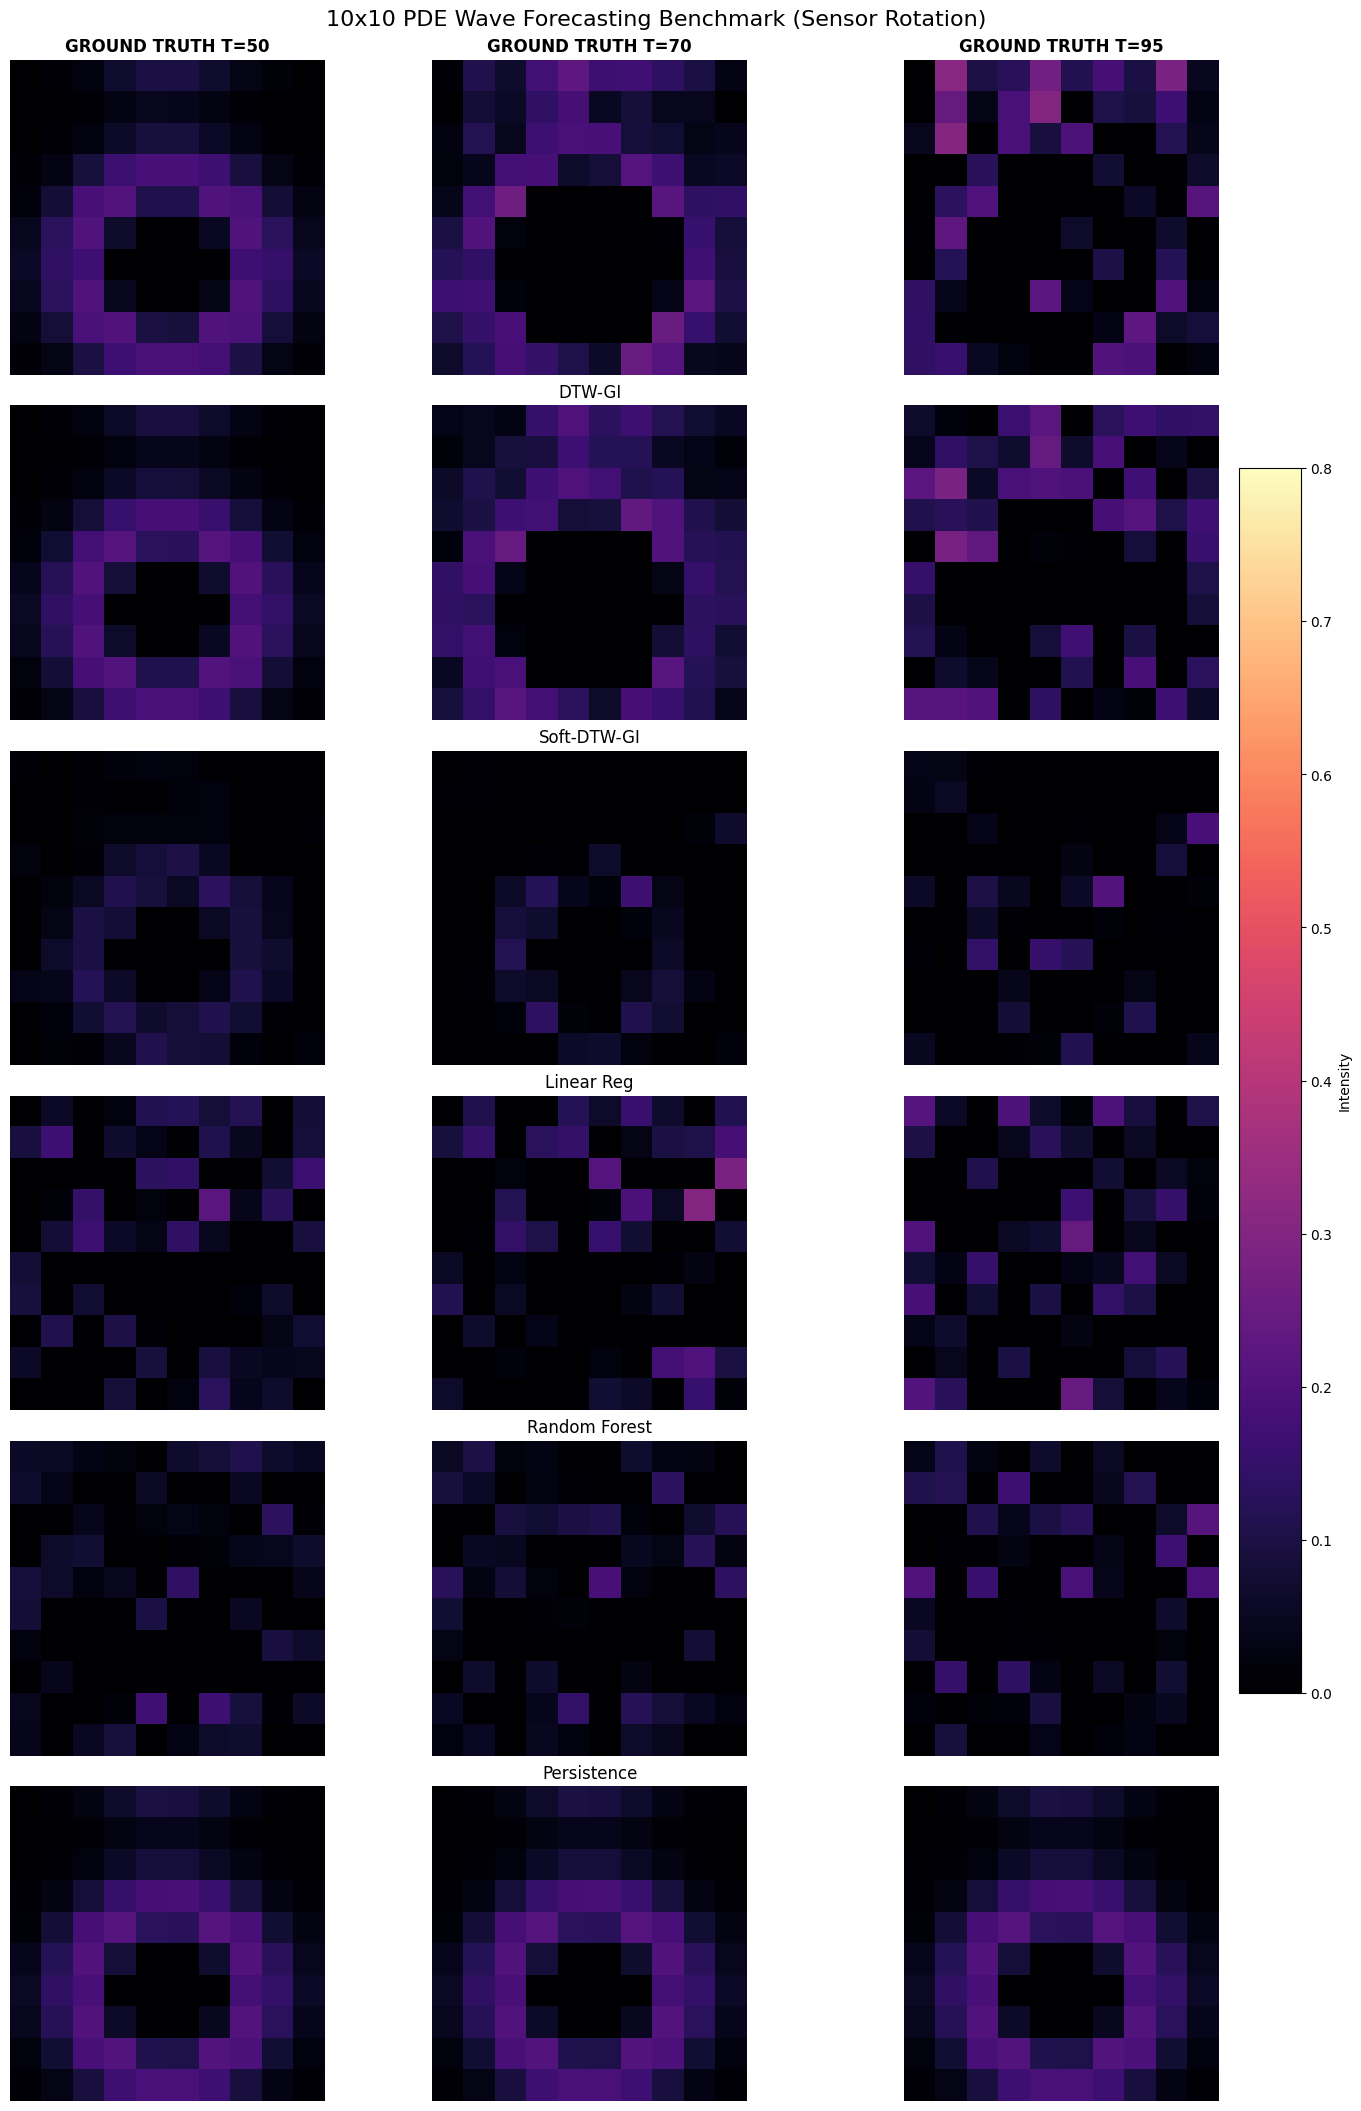


FINAL MSE RESULTS
       Method      MSE
       DTW-GI 0.005896
  Persistence 0.021091
Random Forest 0.022631
  Soft-DTW-GI 0.027854
   Linear Reg 0.032799
          DTW 0.035563


In [ ]:
# Summary plot and table
viz_methods = ["DTW-GI", "Soft-DTW-GI", "Linear Reg", "Random Forest", "Persistence"]
nrows = 1 + len(viz_methods)

fig, axes = plt.subplots(nrows, 3, figsize=(14, 3.5 * nrows), constrained_layout=True)
t_idx = [0, 20, 45]

# Row 0: Ground Truth
for i, t in enumerate(t_idx):
    img = (y_t_sample[t] @ P_VIZ).reshape(GRID_SIZE, GRID_SIZE)
    axes[0, i].imshow(img, cmap='magma', vmin=0, vmax=0.8, interpolation='nearest')
    axes[0, i].set_title(f"GROUND TRUTH T={L+t}", fontweight='bold')
    axes[0, i].axis('off')

# Subsequent Rows
for r, m in enumerate(viz_methods):
    if m in plot_data:
        y_hat = plot_data[m]
        for i, t in enumerate(t_idx):
            img_hat = (y_hat[t] @ P_VIZ).reshape(GRID_SIZE, GRID_SIZE)
            im = axes[r+1, i].imshow(img_hat, cmap='magma', vmin=0, vmax=0.8, interpolation='nearest')
            
            if i == 1: axes[r+1, i].set_title(f"{m}", fontsize=12)
            axes[r+1, i].axis('off')
    else:
        for i in range(3): axes[r+1, i].axis('off'); axes[r+1, 1].set_title(f"{m} (Failed)")

fig.colorbar(im, ax=axes[:, 2], location='right', label='Intensity', shrink=0.6)
plt.suptitle(f"10x10 PDE Wave Forecasting Benchmark (Sensor Rotation)", fontsize=16)
plt.show()

# Final Table
print("\n" + "="*40)
print("FINAL MSE RESULTS")
print("="*40)
final_df = pd.DataFrame(list(metrics.items()), columns=['Method', 'MSE'])
print(final_df.sort_values(by='MSE').to_string(index=False))

DTW-GI dramatically outperforms all baselines because it exactly matches the latent structure of the data: a nearly unique temporal alignment coupled with a rigid spatial transformation. In contrast, Soft-DTW-GI introduces entropy regularization that biases the alignment in this low-noise physics-driven setting, leading to significantly worse reconstruction despite visually plausible forecasts.